# Assignment

In [ ]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import numpy.matlib

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [25]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [26]:
def Q_values(x, W1, W2, bias_W1, bias_W2):

    # Neural activation: input layer -> hidden layer
    act1 = np.dot(W1, x) + bias_W1
    # print(act1)
    out1 =  np.maximum(act1, 0)
    # Neural activation: hidden layer -> output layer
    act2 = np.dot(W2, out1) + bias_W2
    # print(act2)
    Q =  np.maximum(act2, 0)



    # YOUR CODE ENDS HERE
    return Q, out1

In [27]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS


N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

## INITALISE YOUR NEURAL NETWORK...
W1=np.random.uniform(0,1,(N_h,N_in))
print(W1.shape)

W1=np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
# print(W1.shape)

W2=np.random.uniform(0,1,(N_a,N_h))
# print(W2.shape)

W2=np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))

bias_W1 = np.zeros((N_h,1))
bias_W2 = np.zeros((N_a,1))

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


(200, 58)


In [22]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...
# SARSA
for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        a,_=np.where(allowed_a==1)

        Q, out1 = Q_values(X.reshape((-1,1)), W1, W2, bias_W1, bias_W2)

        prob = np.random.rand()
            # prob = 1 #for q learning

        Q_a = Q[a] #the q values of allowed actions

        if prob>epsilon_f:
            a_agent = a[np.argmax(Q_a)]
        else:
            # choose random value
            ranChoice = np.random.randint(0, a.size)
            a_agent = a[ranChoice]
                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            b1 = R - Q[a_agent]
            R_save[n,:] = (1/10000) * R + (1 - (1/10000)) * R_save[n-1,:]
            N_moves_save[n,:] = (1/10000) * i + (1 - (1/10000)) * N_moves_save[n-1,:]
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Q_next, _ = Q_values(X_next.reshape((-1,1)), W1, W2, bias_W1, bias_W2)


            an,_=np.where(allowed_a_next==1)
            # Sarsa
            prob = np.random.rand()
            # prob = 1 #for q learning

            Q_an = Q_next[an] #the q values of allowed actions

            # if prob>epsilon_f:
            #     an_agent = an[np.argmax(Q_an)]
            # else:
            #     # choose random value
            #     ranChoice = np.random.randint(0, an.size)
            #     an_agent = an[ranChoice]
            # # Sr
            # b1 = (R + gamma * Q_next[an_agent]) - Q[a_agent]
            # Q learning
            b1 = (R + gamma * max(Q_next[an]) - Q[a_agent])
            # q -> max(Q_next[an])

        delta2 = b1 * np.heaviside(Q, 0)
        delta1 = np.dot(W2.T, delta2) * np.heaviside(out1, 0)

        W2 += eta * np.outer(delta2, out1)
        W1 += eta * np.outer(delta1, X)

        bias_W2 += eta * delta2
        bias_W1 += eta * delta1
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

KeyboardInterrupt: ignored

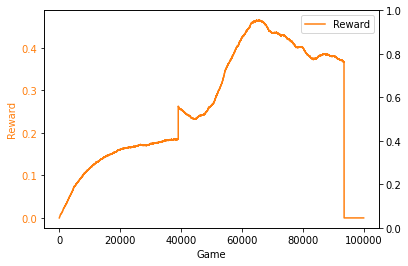

In [23]:
fig, ax1 = plt.subplots()

color=list(plt.rcParams['axes.prop_cycle'])[1]['color']
ax1.set_xlabel('Game')
ax1.set_ylabel('Reward', color=color)
ax1.plot(R_save,color=color,label='Reward')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color=list(plt.rcParams['axes.prop_cycle'])[0]['color']

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


plt.show()

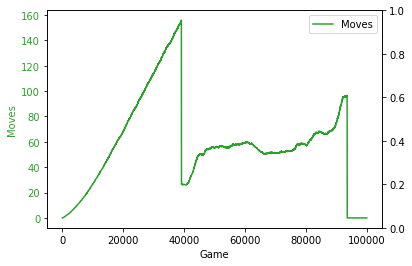

In [24]:
fig, ax1 = plt.subplots()


color=list(plt.rcParams['axes.prop_cycle'])[2]['color']
ax1.set_xlabel('Game')
ax1.set_ylabel('Moves', color=color)

ax1.plot(N_moves_save,color=color,label='Moves')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color=list(plt.rcParams['axes.prop_cycle'])[0]['color']

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


plt.show()